In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
from fastai.collab import *

In [2]:
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating'],
                     usecols=['user','movie','rating'])
ratings_head = ratings.head(10)
ratings_head

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
5,298,474,4
6,115,265,2
7,253,465,5
8,305,451,3
9,6,86,3


In [4]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [6]:
user_name   = ifnone(user_name,   ratings.columns[0])
item_name   = ratings.columns[1]
rating_name = ratings.columns[2]
cat_names = [user_name,item_name]
splits = RandomSplitter()(range_of(ratings))
to = TabularCollab(ratings, [Categorify], cat_names, y_names=[rating_name], y_block=TransformBlock(), splits=splits, reduce_memory=False)
dls = to.dataloaders(path=path)

NameError: name 'user_name' is not defined

In [ ]:
#Way of creating data loaders that doesnt work
# dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

In [40]:
dls.classes.keys()

dict_keys(['user', 'movie'])

In [41]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['movie'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [42]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)

        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])

        return sigmoid_range(res, *self.y_range)

In [43]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.950420,0.928347,00:06
1,0.849040,0.867217,00:06
2,0.741877,0.824727,00:06
3,0.615719,0.812018,00:06
4,0.483995,0.812951,00:06


# Trying to switch to categorization problem

In [6]:
ratings.dtypes

user       int64
movie      int64
rating     int64
title     object
dtype: object

In [28]:
# ratings['rating'] = ratings['rating'] - 1

In [7]:
user_name   = ratings.columns[0]
item_name   = ratings.columns[1]
rating_name = ratings.columns[2]
cat_names = [user_name,item_name]
splits = RandomSplitter()(range_of(ratings))
to = TabularCollab(ratings, [Categorify], cat_names, y_names=[rating_name], y_block=CategoryBlock, splits=splits, reduce_memory=False)
dls = to.dataloaders(path=path)

In [8]:
dls.show_batch()

,user,movie,rating
0,542,509,4
1,422,260,3
2,311,498,4
3,595,298,4
4,617,201,1
5,158,82,5
6,836,268,3
7,474,283,3
8,466,455,3
9,554,288,3


In [9]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 5),
#             nn.Softmax()
        )
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
#         print(x.shape)
#         print(x)
        return x

In [10]:
emb_sizes = get_emb_sz(dls)
emb_sizes

[(944, 74), (1650, 101)]

In [11]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [11]:
# user_factors = Embedding(*emb_sizes[0]).cuda()
# item_factors = Embedding(*emb_sizes[1]).cuda()
# layers = nn.Sequential(
#     nn.Linear(emb_sizes[0][1]+emb_sizes[1][1], 100),
#             nn.ReLU(),
#             nn.Linear(100, 5),
# #             nn.Softmax()
# ).cuda()

# # item_factors(x[:,1].cuda())

# embs = user_factors(x[:,0]),item_factors(x[:,1])
# return_x = layers(torch.cat(embs, dim=1))

In [17]:
def loss_function(inp, target):
    return F.cross_entropy(inp, target.squeeze(1).long())

In [18]:
model = CollabNN(*emb_sizes)
learn = Learner(dls, model, loss_func=loss_function)

In [19]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.296503,1.306253,00:06
1,1.259812,1.266721,00:06
2,1.215109,1.246595,00:06
3,1.180476,1.227555,00:06
4,1.123366,1.233291,00:06


SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=9.12010818865383e-07)

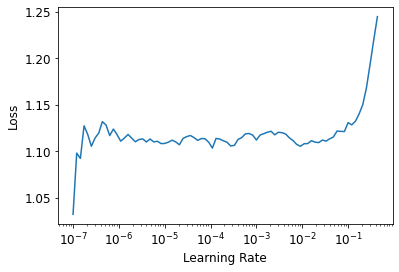

In [20]:
learn.lr_find()